Principle Component Analysis (PCA)

Possible dimensionality reduction technique that is helpful to reduce data into a lower number of dimensions than the original input dimensions.

Was previously used to reduce data storage, but is now more commonly used to visualize data into a simple 1D, 2D, or even 3D plot.

*Note: in this notebook, the words dimensions and features are interchangeable.*

The axis to which we reduce the data to must capture a great deal of the variation in the original data. It must be informative enough to enable using the reduced data to make informative decisions.

After performing PCA, the goal a common technique is to reconstruct the original data from the reduced data set.

There are two main targets while conducting the Principle Component Analysis:

1- Minimize the reconstruction error
2- Maximize the variance of reconstructions

It can be proved that trying to achieve one of the two targets simultaneously gurantees the other.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

# Load the breast cancer disgnostic dataset
dataset = load_breast_cancer()
features = dataset.data
target = dataset.target

To properly implement PCA, the data must be centered. Therefore, the mean will be subtracted from each data point. Moreover, the features will also be standardized as some of the given features might have a larger scale than others. If this point is not to be done, the resulting PCA could possibly be skewed.

In [15]:
# Centering and standardizing the data
# Subtract the mean from each feature and divide it by its standard deviation.
# Subtracting the mean --> centers the data
# Dividing by the standard deviation --> ensures proper scaling.

featuresStandardized = (features - np.mean(features, axis=0)) / np.std(features, axis=0)

The next step is to compute the covariance matrix. The covariance matrix is essentially helpful as it helps visualize mathematically the relations between data and shows how features are correlated to each other. Helps in finding the direction having the most variation.

In [16]:
# Computing the covariance matrix:

covarianceMatrix = np.cov(featuresStandardized.T)

# Can also be written as covarianceMatrix = np.cov(featuresStandardized, rowvar=False).
# This point just aims to explain that every column is a feature, not every row (default is feature per row)

print(covarianceMatrix)

[[ 1.00176056e+00  3.24351929e-01  9.99612069e-01  9.89095475e-01
   1.70881506e-01  5.07014640e-01  6.77955036e-01  8.23976636e-01
   1.48001350e-01 -3.12179472e-01  6.80285970e-01 -9.74887767e-02
   6.75358538e-01  7.37159198e-01 -2.22992026e-01  2.06362656e-01
   1.94545531e-01  3.76831225e-01 -1.04504545e-01 -4.27163418e-02
   9.71245907e-01  2.97530545e-01  9.66835698e-01  9.42739295e-01
   1.19826732e-01  4.14190751e-01  5.27839123e-01  7.45524434e-01
   1.64241985e-01  7.07832563e-03]
 [ 3.24351929e-01  1.00176056e+00  3.30113223e-01  3.21650988e-01
  -2.34296930e-02  2.37118951e-01  3.02950254e-01  2.93980713e-01
   7.15266864e-02 -7.65717560e-02  2.76354360e-01  3.87037830e-01
   2.82169018e-01  2.60302460e-01  6.62542133e-03  1.92312595e-01
   1.43545353e-01  1.64139495e-01  9.14323671e-03  5.45533955e-02
   3.53193674e-01  9.13650301e-01  3.58669926e-01  3.44150782e-01
   7.76398084e-02  2.78318729e-01  3.01555198e-01  2.95835766e-01
   1.05192783e-01  1.19415220e-01]
 [ 9.9

Eigenvalue Decomposition:

Theoretically, after implementing PCA, the most axis conatining the most variance of the data is the set of eigenvectors.

Given that the covariance matrix is a square symmetric matrix, and according to the spectral theorem, there exists an orthogonal set of eigenvectors as a basis.

This means that for a covariance matrix of dimension 30, the data can be represented using a set of 30 dimensions, each orthogonal to one another (right angles from one another). The eigenvalues on the other hand portray the variance inherent in each direction.

If the eigenvectors are sorted with the highest eigenvalues, the n new dimensions can be represented with the highest n eigenvectors.

In [17]:
# Compute eigenvalues and eigenvectors:

eigenvalues, eigenvectors = np.linalg.eig(covarianceMatrix)

# Sort the eigenvectors by the highest eigenvalues
# np.argsort(eigenvalues)[::-1] returns the indicies of the highest eigenvalues.
eigenvectors = eigenvectors[np.argsort(eigenvalues)[::-1]]

Explained Variance Ratio:


"Variance Ratio refers to the ratio of variance explained by each principal component in a Principal Component Analysis (PCA). It is used to determine the optimal number of dimensions needed to explain the variance in a dataset, with the total ratio summing up to 1."
https://www.sciencedirect.com/topics/computer-science/variance-ratio


In [24]:
# Simplified previous operations to a class.

class PCA:
  def __init__(self, numberOfPrincipleComponents=2):
    self.numberOfPrincipleComponents = numberOfPrincipleComponents
    self.eigenvectors = None
    self.eigenvalues = None
    self.mean = None
    self.std = None
    self.covarianceMatrix = None
    self.explainedVarianceRatio = None
    self.pca = None
    self.reconstructed = None

  def fit(self, features):
    self.mean = np.mean(features, axis=0)
    self.std = np.std(features, axis=0)

    # Precautionary step to ensure no featurs having a standard deviation of zero do not halt the program.
    self.std[self.std == 0] = 1

    standardized = (features - self.mean) / self.std
    self.covarianceMatrix = np.cov(standardized.T)
    eigenvalues, eigenvectors = np.linalg.eig(self.covarianceMatrix)
    # By default, np.argsort sorts in ascending order. For this model, we need it to sort descendingly, thus the -1.
    sortedIndicies = np.argsort(eigenvalues)[::-1]
    self.eigenvalues = eigenvalues[sortedIndicies]
    # Sorts columns, not rows.
    self.eigenvectors = eigenvectors[:,sortedIndicies]

    totalVariance = np.sum(eigenvalues)
    self.explainedVarianceRatio = self.eigenvalues / totalVariance

    return self

  def project(self,features):
    standardized = (features - self.mean) / self.std
    # The np.dot function projects the input data onto the provided eigenvectors.
    pca = np.dot(standardized, self.eigenvectors[:, :self.numberOfPrincipleComponents])
    self.pca = pca
    return pca

  def reconstruct(self, projectedFeatures):
    # Reconstruct the data after projecting it on the prinicple axes:
    reconstructed = np.dot(projectedFeatures, self.eigenvectors[:, :self.numberOfPrincipleComponents].T) * self.std + self.mean
    self.reconstructed = reconstructed
    return reconstructed

  def reconstructionError(self, features):
    # Calculating the error in the reconstructed data
    projectedData = self.project(features)
    reconstructedData = self.reconstruct(projectedData)

    error = np.mean((features - reconstructedData)**2)

    print(f"Reconstruction Error using MSE:{error:.3f}")
    return error


  def plot(self,target):
    # Plotting a scatter plot
    plt.figure()
    color = ['r','g']
    names = ['Malignant', 'Benign']
    for i in range(len(color)):
      plt.scatter(self.pca[target==i,0], self.pca[target==i,1], c=color[i], label=names[i])
    plt.title("PCA Plot of Two Components")
    plt.xlabel(f"Principal Component 1 With Explained Variance of:{self.explainedVarianceRatio[0]:.3%}")
    plt.ylabel(f"Principal Component 2 With Explained Variance of:{self.explainedVarianceRatio[1]:.3%}")
    plt.legend()

    plt.figure()
    # Plot a bar chart for the explained variance of all features in the dataset
    barComponents=np.arange(1, len(self.explainedVarianceRatio)+1)
    plt.bar(barComponents, self.explainedVarianceRatio,align='center', label='Explained Variance of Each Feature')

    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Principle Component Index')
    plt.title('Variance Ratio Plot')

Reconstruction Error using MSE:809.793


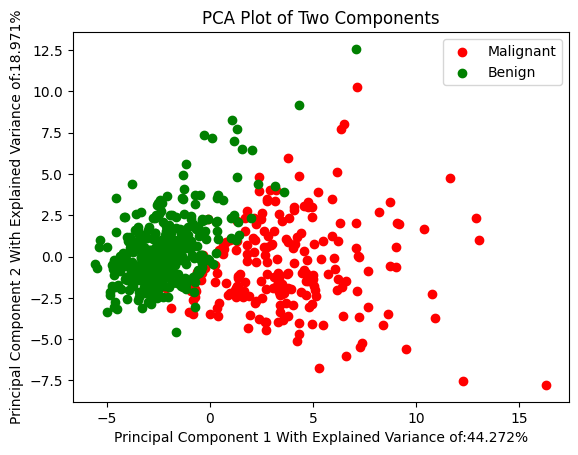

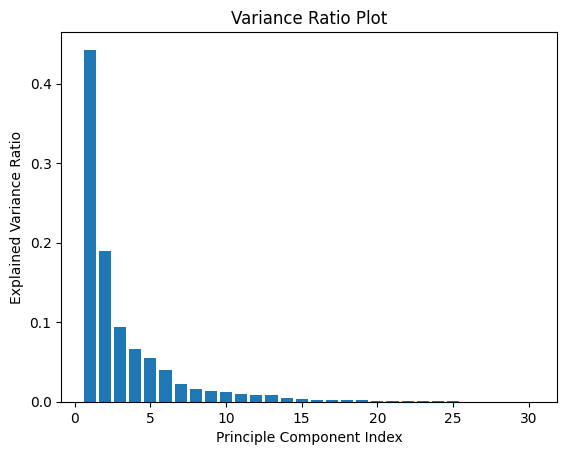

In [25]:
# Testing PCA class:

pca = PCA(numberOfPrincipleComponents=2)
pca.fit(features)
pca.project(features)
pca.plot(target)
reconstructionError = pca.reconstructionError(features)